Blatt 4
---

Übungstermin: 17. 05. 2017

Ansehen auf
[Github](https://github.com/jonasitzmann/grundlagen_ml/blob/master/ex4.ipynb)
oder mit 
[Google Colaboratory](https://colab.research.google.com/github/jonasitzmann/grundlagen_ml/blob/master/ex4.ipynb)
ausführen.

In [1]:
import os
if not os.path.exists('grundlagen_ml'):
  print('cloning repository github.com/jonasitzmann/grundlagen_ml')
  os.system('git clone https://github.com/jonasitzmann/grundlagen_ml')
  os.chdir('grundlagen_ml')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import diag
from functools import partial
from helpers import plot, design_mat_polynomial, get_y, plot_samples
from numpy.linalg import inv
from numpy.random import normal
from scipy.stats import norm # pdf for normal distribution
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # scipy throws FutureWarning
np.random.seed(1)
%matplotlib inline

## Task 4.1 Cramer-Rao Schranke am Boccia-Beispiel:
<font color='#0d2b5b'>
Betrachten Sie das Boccia-Datenmodell aus dem Vorlesungsskript mit $y_i = wx^2 + \nu_i$ mit konstanter
Anfangsgeschwindigkeit $x = 0.5$ und dem Schätzer  
$$\hat\omega= \frac 1N \sum_{i=1}^N \frac{y_i}{x^2}$$
Dabei sei $\nu_i \sim \mathcal{N} (0, \sigma^2)$ normalverteiltes Rauschen mit Varianz $\sigma^2 = 0.1$.  
</font>

In [3]:
class BocciaDistribution:
    def __init__(self, sigma=0.1, x_0=0.5, w=1):
        self.sigma = sigma
        self.x_0 = x_0
        self.w = w
        self.mu = self.w * self.x_0**2

    def get_samples(self, n):
        noise = np.random.normal(0, self.sigma, n)
        ys = noise + self.mu
        return ys

In [4]:
def sample_mean(ys):
    ys = np.array(ys)
    mean = np.sum(ys, axis=0) / len(ys)
    mean = mean.reshape(ys.shape[1:])
    return mean

def sample_variance(ys):
    ys = np.array(ys)
    return np.sum((ys - sample_mean(ys))**2) / (len(ys) - 1)

def estimate_omega(x, ys):
    omega = sample_mean(ys / x**2)    
    return omega

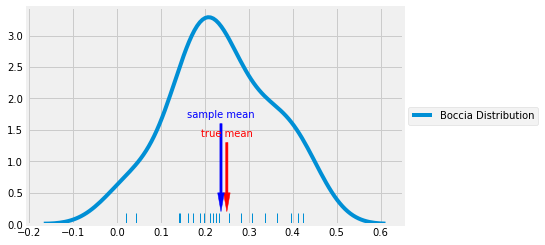

In [5]:
distribution = BocciaDistribution()
samples = distribution.get_samples(20)
plot_samples(samples, distribution)

<font color='#0d2b5b'>
Zeige experimentell über je $100$ Wiederholungen, dass für $N \in \{ 1, 2, 3, 5, 10, 100, 1000\}$
die Varianz der Schätzung, d.h. $Var(\hat\omega)$
gegen die Cramer-Rao Schranke konvergiert.
Plotte dazu $Var(\hat\omega)$ und 
$\frac{\sigma^2}{Nx^2}$
in Abhängigkeit von $N$.  
</font>

In [6]:
def calc_cramer_rao_bound(distribution, n_samples):
    return distribution.sigma**2 / (n_samples* distribution.x_0**4)

def calc_boccia_sample_variance(distribution, n_samples, n_reps=100):
    return sample_variance(
    [estimate_omega(distribution.x_0, distribution.get_samples(n_samples))
     for _ in range(n_reps)])

In [7]:
ns = np.array([1, 3, 5, 10, 100, 1000, 10000])
distribution = BocciaDistribution()
cramer_rao_bounds = [calc_cramer_rao_bound(distribution, n) for n in ns]
sample_variances = [calc_boccia_sample_variance(distribution, n) for n in ns]

Im folgenden Plot verwende ich für beide Achsen eine logarithmische Scala.  
Dadurch sind die $N$s gleichmäßiger verteilt.  
Außerdem ist so die erwartete Funktion eine Gerade, sodass etwaige 
Abweichungen leicht zu erkennen sind.

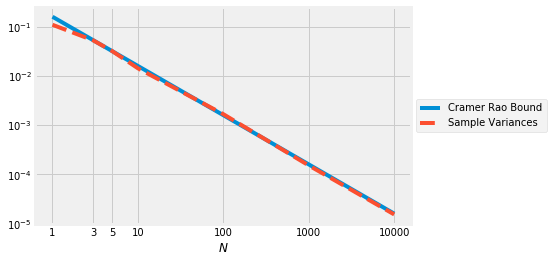

In [8]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$N$')
ax.plot(ns, cramer_rao_bounds, label="Cramer Rao Bound")
ax.plot(ns, sample_variances, label="Sample Variances", ls='--')
plt.xticks(ns, [str(n) for n in ns], axes=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

<font color='#1d478c'>
Wie verändern sich die Schranke und die Schätzungen bei Variation von $\sigma^2$.  
</font>

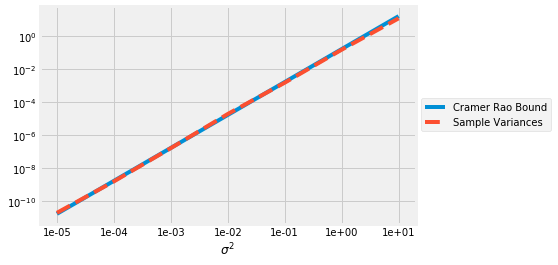

In [9]:
sigmas = 10**np.linspace(-5, 1, 7)
n_samples = 100
distributions = [BocciaDistribution(sigma=sigma) for sigma in sigmas]
cramer_rao_bounds = [calc_cramer_rao_bound(distribution, n_samples) for distribution in distributions]
sample_variances = [calc_boccia_sample_variance(distribution, n_samples) for distribution in distributions]

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\sigma^2$')
ax.plot(sigmas, cramer_rao_bounds, label="Cramer Rao Bound")
ax.plot(sigmas, sample_variances, label="Sample Variances", ls='--')
plt.xticks(sigmas, ["{:.0e}".format(sigma) for sigma in sigmas], axes=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Je höher die Varianz, desto höher auch die Schranke bzw. die Varianz in $\boldsymbol{\hat\omega}$  
Dies lässt sich intutiv durch die schlechtere Qualität der Daten erklären.

## Task 4.2 Regularisierte Polynom-Regression:
<font color='#1d478c'>
Berechnen Sie die Regressionsformel für die quadratische Fehlerfunktion
$$
E = \frac12 \sum_{i=1}^N \left( y(x_i) - \hat y(x_i)\right)^2
+\lambda \frac12 \sum_{m=0}^M \hat\omega_m^2 \left(e^m-1\right)
$$
mit speziellem Regularisierungsterm gewichtet mit Parameter $\lambda$ für einen Polynomapproximator
$$
\hat y(x) = \sum_{m_0}^M \hat\omega_m^m x_m
$$
.  
</font>

Zunächst bringe ich die Fehlerfunktion in eine Matrixform.
Wie in Übung 2 ist der Fehlervector  
$\mathbf{e} = \mathbf{\hat y} - \mathbf{y}=  \boldsymbol{\hat\omega}^T \mathbf{x} - \mathbf{y}$  
Zudem definiere ich die Regularisierungsmatrix  

$$
\mathbf R =
\begin{pmatrix}
e^0+1 &&\Large 0\\
&\ddots &\\
\Large0&& e^n+1\\
\end{pmatrix}
$$

Damit erhalte ich

\begin{align}
E( \boldsymbol{\hat\omega}) &= \mathbf{e}^T \mathbf{e} + \lambda \boldsymbol{\hat\omega}^T \mathbf{D} \boldsymbol{\hat\omega} \\
&=  \mathbf{y}^T \mathbf{y} - 2\left( \mathbf{y}^T \mathbf{x} \boldsymbol{\hat\omega} \right)
+ \boldsymbol{\hat\omega}^T \mathbf{x}^T \mathbf{x}\boldsymbol{\hat\omega}
+ \lambda \boldsymbol{\hat\omega}^T \mathbf{D} \boldsymbol{\hat\omega}\\
\end{align}

Durch Nullsetzen des Gradienten der Fehlerfunktion ergibt sich:

\begin{align}
\nabla_\boldsymbol{\hat\omega} E(\boldsymbol{\hat\omega}) &= 0 \\
\rightarrow 0 &= 
-2 \mathbf{y}^T \mathbf{x}
+ 2 \boldsymbol{\hat\omega}^T \mathbf{x}^T \mathbf{x}
+ 2 \boldsymbol{\hat\omega}^T \lambda \mathbf{D}\\
\rightarrow \mathbf{y}^T \mathbf{x} &= 
\boldsymbol{\hat\omega}^T \mathbf{x}^T \mathbf{x}
+ \boldsymbol{\hat\omega}^T \lambda \mathbf{D}\\
&= \boldsymbol{\hat\omega}^T 
\left( \mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}\right)\\
\rightarrow \boldsymbol{\hat\omega}^T &= 
\mathbf{y}^T \mathbf{x} 
\left( \mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}\right)^{-1}\\
\rightarrow \boldsymbol{\hat\omega} &= 
\left(\left(
\mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}
\right)^{-1}\right)^T
\mathbf{x}^T \mathbf{y}
\end{align}

Da sowohl
$\mathbf{x}^T \mathbf{x}$ als auch $\lambda \mathbf{D}$
symmetrisch sind, gilt dies auch für die Summe, sodass:
$$
\boldsymbol{\hat\omega} = 
\left(
\mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}
\right)^{-1}
\mathbf{x}^T \mathbf{y}
$$

<font color='#1d478c'>
Welche Idee steckt hinter diesem speziellem Regularisierungsansatz und wie wirkt sich die Regularisierung
auf die Lösungen der Regression aus?
</font>

Gewichte der höheren Polynomgerade sind 'teurer', sodass im Zweifel für einen Fit geringerer Ordnung entschieden wird.  
Streng genommen, ist die Ordnung jeweils dieselbe, jedoch sind die Koeffizienten der hohen Gerade nahe Null,
wenn $\lambda$ klein ist.

## Task 4.3 Bias-Varianz Dilemma am Beispiel der Polynom-Regression:
<font color='#1d478c'>
Untersuchen Sie den Einfluss der oben eingeführten Regularisierung auf die Schätzgenauigkeit.  
Als Datenmodell sei das Polynom $y(x, w) + \nu$ gegeben mit wahren Parametern  
$w_0 = 0.8$, $w_1 = 2.4$, $w_2 = −1.55$, $w_3 = −0.15$, $w_4 = 0.1$ und $\nu \sim\mathcal{n} (0, \sigma^2 )$
mit $\sigma^2 = 2$.  
</font>

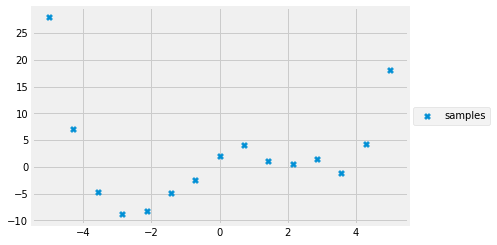

In [10]:
true_omega = [0.8, 2.4, -1.55, -0.15, 0.1]
def get_samples(sigma = 2):    
    xs = np.linspace(-5, 5, 15)
    ys = get_y(true_omega, xs) + normal(0, sigma, len(xs))
    return xs, ys
xs, ys = get_samples()
plot(xs, ys)

In [11]:
def p_inv_reg(A, weight, d_mat):
    return inv(A.T @ A + weight * d_mat) @ A.T
 
def polyfit_reg(x, y, weight, d_mat_diagonal):
    order = len(d_mat_diagonal) - 1
    x, y = [np.array(a).reshape(-1, 1) for a in [x, y]]
    design_mat = design_mat_polynomial(x, order)
    params = p_inv_reg(design_mat, weight, diag(d_mat_diagonal)) @ y
    return params.reshape(-1, 1)

<font color='#1d478c'>
Schätzen Sie wiederholt Modellparameter $\hat\omega$ für Polynome 8-ten Grades mittels der regularisierten
Regression aus Aufgabe 3.2. Erstellen Sie dazu $100$ Datensätze bestehend aus je $20$ Datenpunkten
$(x_i , y(x_i ) + \nu_i)$ mit uniform verteilten $x_i \in [−5, 5]$ und wiederholen Sie die Schätzung der Parameter
für jeden Datensatz und Regularisierungen $\lambda \in {0, 10^{−5} , 10{−4} , . . . , 10^5}$.  
</font>

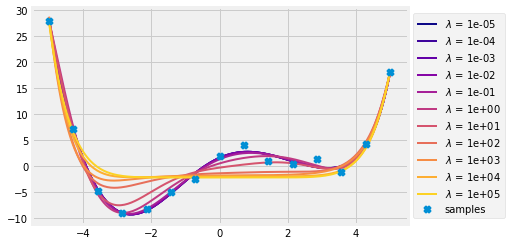

In [12]:
order = 8
lambdas = 10**np.linspace(-5, 5, 11)
d_mat_diagonal = [np.exp(m) + -1 for m in range(order + 1)]
coeff_dict = {"$\lambda$ = {:.0e}".format(weight) : polyfit_reg(xs, ys, weight, d_mat_diagonal) for weight in lambdas}
plot(xs, ys, coeff_dict, lw=2)

<font color='#1d478c'>
Welchen Einfluss hat $\lambda$ auf die Aufteilung des Schätzfehlers
$\left< ||w − \hat\omega||^2\right>$
in Bias- und Varianz-Anteile?
Plotten Sie dazu den Bias des Schätzers, d.h.
$||\left<\hat\omega\right> − w||^2$,
sowie dessen Varianz
$\left< ||\hat\omega − \left< \hat\omega \right>||^2 \right>$
in Abhängigkeit von $\lambda$.  
</font>

Zunächst fülle ich die wahren Koeffizienten mit Nullen auf, damit der Grad
mit dem geschätzen Modell 8. Grades übereinstimmt.

In [13]:
true_omega_padded = np.zeros(order+1)
true_omega_padded[:5] = true_omega
n_estimations = 100

In [14]:
def calc_bias(weight, true_omega, d_mat_diagonal):
    estimated_omegas = np.array([
        polyfit_reg(*get_samples(), weight, d_mat_diagonal)
                        for _ in range(n_estimations)]).reshape(n_estimations, -1)  
    mean_omega = sample_mean(estimated_omegas)
    deviation = np.array(mean_omega - true_omega)
    return deviation.T @ deviation

def calc_variance(weight, d_mat_diagonal):
    estimated_omegas = np.array([
        polyfit_reg(*get_samples(), weight, d_mat_diagonal)
                        for _ in range(n_estimations)]).reshape(n_estimations, -1)  
    mean_omega = sample_mean(estimated_omegas)
    deviations = np.array([
        ((omega - mean_omega)**2).sum()
        for omega in estimated_omegas])
    return sample_mean(deviations)

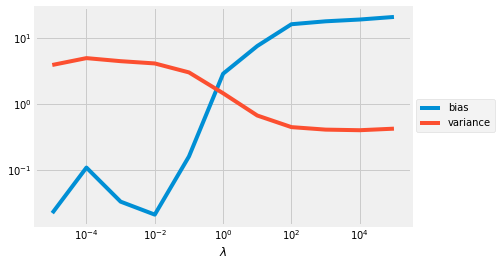

In [15]:
biases = [calc_bias(weight, true_omega_padded, d_mat_diagonal) for weight in lambdas]
variances = [calc_variance(weight, d_mat_diagonal) for weight in lambdas]


fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.plot(lambdas, biases, label="bias")
ax.plot(lambdas, variances, label="variance")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Man sieht, dass mit zunehmender Regularisierung die Varianz abnimmt, der Bias jedoch wächst.
Das liegt daran, dass die Regularisierung die Gewichte in Richtung der $0$ "zieht",
es wird also das Vorwissen, dass die Parameter klein sind, in die Schätzung eingebunden.  
Ohne Regularisierung, wird alleine auf Basis der Datenpunkte optimiert, sodass die Schätzung stärker
von variierenden Stichproben beeinflusst wird.